In [20]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import pandas as pd

In [21]:
def file2df(file):
    with open(file, 'r') as ff:
        line = ff.readline()
        cols = line.strip('#').split()
    return pd.read_csv(file, comment='#', delim_whitespace=True, names=cols)

In [22]:
%timeit data = Table.read('Astr511HW1data.dat', format='ascii')

13 s ± 309 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit df = file2df('Astr511HW1data.dat')

1.78 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
#  pandas wins over astropy Table by about a factor of 7! 
df['ug'] = df['u'] - df['g'] 
df['gr'] = df['g'] - df['r'] 

In [57]:
# photometric metallicity
def FeHpoly(x, y):
    # basic mapping from Ivezic++2008
    A, B, C, D, E, F, G, H, I, J = -13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20 
    return A+B*x+C*y+D*x*y+E*x**2+F*y**2+G*x**2*y+H*x*y**2+I*x**3+J*y**3
    
def FeHpoly2(x, y):
    # try dot product 
    C = np.array([-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20])  
    A = np.array([1, x, y, x*y, x**2, y**2, x**2*y, x*y**2, x**3, y**3]) 
    return np.dot(C, A)  

# set default FeH for red stars
def photomFeH(ug, gr, grCutRed=0.6, redFeHdefault=-0.6):
    return np.where(gr > grCutRed, redFeHdefault, FeHpoly(ug, gr))

# like photomFeH but using dot product instead of explicit polynomial 
def photomFeH2(ug, gr, grCutRed=0.6, redFeHdefault=-0.6):
    return np.where(gr > grCutRed, redFeHdefault, FeHpoly2(ug, gr))

# it's always a good idea to control extremes...
def limitRange(vec, min, max):
    vec[vec < min] = min
    vec[vec > max] = max
    return vec

In [58]:
def SlowMetallicity(x, y):
    A, B, C, D, E, F, G, H, I, J = -13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20 
    
    Fe_H = -0.6*np.ones(len(y)) # set default to -0.6 
    for i in range(len(y)):
        if y[i] < 0.6: 
            Fe_H[i] = A + B*x[i] + C*y[i] + D*x[i]*y[i] + E*x[i]**2 + F*y[i]**2 + G*x[i]**2*y[i] + H*x[i]*y[i]**2 + I*x[i]**3 + J*y[i]**3
    
    return Fe_H

In [73]:
def getMainSequenceDistanceKpc(gi,FeH,r): 
    """Get stellar distance in kpc"""

    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    # distance in kpc
    Dkpc = 0.01 * 10**(0.2*(r-Mr))
    return Dkpc

def getMainSequenceAbsMag(gi,FeH): 
    """Get absolute magnitude for main sequence stars using eqs. 2, 5, and 7 from
       Ivezic et al. 2008 (ApJ, 684, 287)"""

    # valid for 0.2 < g-i < 4.0 
    Mr0 = -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    # offset for metallicity, valid for -2.5 < FeH < 0.2
    Mr = Mr0 + 4.50 - 1.11*FeH - 0.18*FeH**2
    return Mr

In [65]:
# FeH limited to -2.5 to 0.5 range
%timeit FeHfast = photomFeH(df['ug'], df['gr']) 

31.1 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
# try dot product (as Jess and Ed did)
%timeit FeHfast2 = photomFeH2(df['ug'], df['gr']) 

230 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
# demonstrate how awfully slow python loop is 
%timeit FeHslow = SlowMetallicity(df['ug'], df['gr']) 

24.8 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
# fast version is faster than slow version about 75 times! dot product slower about 8 times than fast version

In [71]:
# and the winner is: 
df['FeH'] = limitRange(photomFeH(df['ug'], df['gr']), -2.5, 0.5)

In [74]:
def doAstr511HW1(df):
    """Make a four-panel plot for Astr511 homework #1"""

    # for consistency with old code
    ug = df['ug']
    gr = df['gr']
    r = df['r']
    gi = df['g']-df['i']
    FeH = df['FeH']
    Dkpc = getMainSequenceDistanceKpc(gi,FeH,r)

    # get bin centers and ln(rho) from a vector of distances
    def getLNrho(D):
        # dN/dD 
        hist, bins = np.histogram(D, bins=250)
        # here we need to go from counts per D bin to volume density
        # rho = dN / dV = dN/dD * dD/dV,
        # where dV/dD = (dOmega/Asky) * 4pi * Dmean^2  
        # area of the full sky: Asky = 41,253 sq.deg. 
        # dOmega for this dataset: dOmega = 314 sq.deg. 
        dVdD = 314.0/41253 * 4*np.pi*(bins[1:]**2+bins[:-1]**2)/2
        rho = hist / dVdD     
        LNhist = np.log((1+rho))
        center = (bins[:-1]+bins[1:])/2
        # width = 0.7*(bins[1]-bins[0])
        return center, LNhist

    def plotBin(D, gr, grMin, grMax, ax, histcolor):
        mask = ((gr>grMin) & (gr<=grMax)) 
        Dkpc1 = D[mask]
        center, LNhist = getLNrho(Dkpc1)
        ax.plot(center, LNhist, drawstyle='steps', color=histcolor)   

    # 
    plot_kwargs = dict(color='k', linestyle='none', marker='.', markersize=1)
    plt.subplots_adjust(bottom=0.1, top=0.93,
                    left=0.1, right=0.9, wspace=0.3, hspace=0.5)

    # 1) for stars with 0.2<g-r<0.4, plot ln[rho(Z)] 
    ax1 = plt.subplot(221)
    mask = ((gr>0.2) & (gr<0.4)) 
    Dkpc1 = Dkpc[mask]
    print('all:', np.size(Dkpc), '0.2<g-r<0.4:', np.size(Dkpc1))
    # for problem 5: see p. 4 in http://faculty.washington.edu/ivezic/Teaching/Astr511/lec5.pdf
    Dok = Dkpc1[(Dkpc1>4.8)&(Dkpc1<5.2)] 
    print('there are', np.size(Dok), 'blue stars between 4.8 kpc and 5.2 kpc')
    center, LNhist = getLNrho(Dkpc1)
    # plot 
    ax1.plot(center, LNhist, drawstyle='steps', color='blue')   
    ax1.set_xlim(0, 25)
    ax1.set_ylim(2, 11)
    ax1.set_xlabel(r'$\mathrm{D (kpc)}$')
    ax1.set_ylabel(r'$\mathrm{ln[\rho(D)]}$')
    ax1.set_title('0.2<g-r<0.4')
    # the limit of data trustworthiness
    ax1.plot([10, 10], [4, 10], '--k')
    ax1.text(4.0, 3.0, r'good', ha='left', va='top')
    ax1.text(12.0, 3.0, r'bad', ha='left', va='top')
 
    # 2) as in 1), but for four g-r bins (0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1.0)
    ax2 = plt.subplot(222)
    # color bins
    plotBin(Dkpc, gr, 0.2, 0.4, ax2, 'blue')
    plotBin(Dkpc, gr, 0.4, 0.6, ax2, 'red')
    plotBin(Dkpc, gr, 0.6, 0.8, ax2, 'green')
    plotBin(Dkpc, gr, 0.8, 1.0, ax2, 'black')
    # 
    ax2.set_xlim(0, 25)
    ax2.set_ylim(2, 11)
    ax2.set_xlabel(r'$\mathrm{D (kpc)}$')
    ax2.set_ylabel(r'$\mathrm{ln[\rho(D)]}$')
    ax2.set_title('Four g-r bins')


    # 3) as in 1), but separately for [Fe/H] < -1, and [Fe/H] > -1
    ax3 = plt.subplot(223)
    mask = (FeH<=-1.0) 
    Dlow = Dkpc[mask]
    plotBin(Dlow, gr, 0.2, 0.4, ax3, 'blue')
    mask = (FeH>-1.0) 
    Dhigh = Dkpc[mask]
    plotBin(Dhigh, gr, 0.2, 0.4, ax3, 'red')
    # 
    ax3.set_xlim(0, 25)
    ax3.set_ylim(1, 10)
    ax3.set_xlabel(r'$\mathrm{D (kpc)}$')
    ax3.set_ylabel(r'$\mathrm{ln[\rho(D)]}$')
    ax3.set_title('0.2<g-r<0.4 and [Fe/H]<,> -1')


    # 4) plot r histograms for the two subsamples from 3) 
    ax4 = plt.subplot(224)
    mask = ((gr>0.2) & (gr<0.4) & (FeH<-1.0)) 
    r1 = r[mask]
    ax4.hist(r1, bins=20, log=True, histtype='step', color='blue')
    mask = ((gr>0.2) & (gr<0.4) & (FeH>-1.0))
    r1 = r[mask]
    ax4.hist(r1, bins=20, log=True, histtype='step', color='red')
    # 
    ax4.set_xlim(13, 22)
    ax4.set_ylim(100, 20000)
    ax4.set_xlabel(r'$\mathrm{r}$')
    ax4.set_ylabel(r'$\mathrm{dN/dr}$')
    ax4.set_title('0.2<g-r<0.4 and [Fe/H]<,> -1')

    plt.show()
    plt.savefig('HW1_figure1.png')

all: 576801 0.2<g-r<0.4: 107673
there are 2588 blue stars between 4.8 kpc and 5.2 kpc


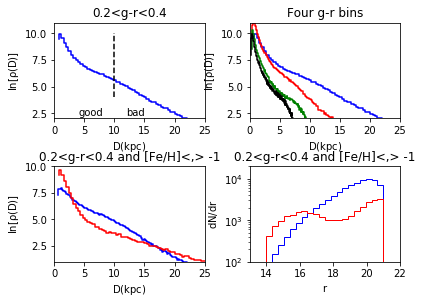

<Figure size 432x288 with 0 Axes>

In [75]:
doAstr511HW1(df)